In [1]:
import datetime

def printbar():
    '''
    打印带有现在时间的分割条

    '''
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print('\n' + '========' * 8 + f'{nowtime}')

一。数据准备

titanic数据集的目标是根据乘客信息预测他们在titanic号撞击冰山沉没后是否能生存。
结构化数据一般会使用pandas中的DataFrame进行预处理。

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import torch 
from torch import nn 
from torch.utils.data import Dataset,DataLoader,TensorDataset

In [3]:
dftrain_raw = pd.read_csv(r'D:\Github\Datasets\Titanic\train.csv')  # 读取训练集csv文件
dftest_raw = pd.read_csv(r'D:\Github\Datasets\Titanic\test.csv')  # 读取测试集csv文件
dftrain_raw.head(10)  # 显示训练集前10条数据

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


Survived:0代表死亡，1代表存活【y标签】

Pclass:乘客所持票类，有三种值(1,2,3) 【转换成onehot编码】

Name:乘客姓名 【舍去】

Sex:乘客性别 【转换成bool特征】

Age:乘客年龄(有缺失) 【数值特征，添加“年龄是否缺失”作为辅助特征】

SibSp:乘客兄弟姐妹/配偶的个数(整数值) 【数值特征】

Parch:乘客父母/孩子的个数(整数值)【数值特征】

Ticket:票号(字符串)【舍去】

Fare:乘客所持票的价格(浮点数，0-500不等) 【数值特征】

Cabin:乘客所在船舱(有缺失) 【添加“所在船舱是否缺失”作为辅助特征】

Embarked:乘客登船港口:S、C、Q(有缺失)【转换成onehot编码，四维度 S,C,Q,nan】


自己的小心得：

1. 仔细分析数据的每个维度，抽出其中可能相关的维度

2. 如果是有限类别，使用onehot编码

3. 如果是二元特征，转换成bool特征

4. 数值特征保留

5. 注意在某些特征维度中，数据的是否缺失可以单独拿出作为一个二元特征

然后进行探索性数据分析EDA

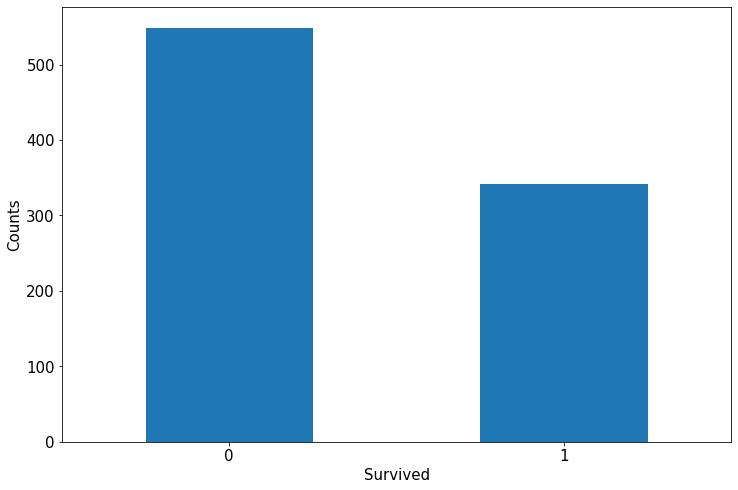

In [4]:
# label分布
ax = dftrain_raw['Survived'].value_counts().plot(kind = 'bar', figsize = (12,8),fontsize=15,rot = 0)
# 将训练集中Survived维度数据按类别计数，并作柱状图，图尺寸长12宽8，字体大小15，旋转角度为0
ax.set_ylabel('Counts',fontsize = 15)
# 设置y轴坐标名称，字体大小为15
ax.set_xlabel('Survived',fontsize = 15)
# 设置x轴坐标名称，字体大小为15
plt.show()
# 显示作图

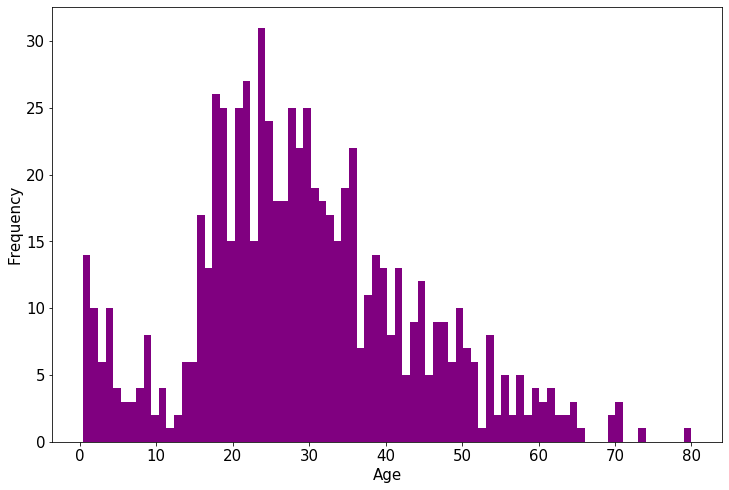

In [5]:
# 年龄分布
ax = dftrain_raw['Age'].plot(kind = 'hist',bins = 80,color= 'purple', figsize = (12,8),fontsize=15)
# 画年龄的直方图，柱数为80
ax.set_ylabel('Frequency',fontsize = 15)
ax.set_xlabel('Age',fontsize = 15)
plt.show()

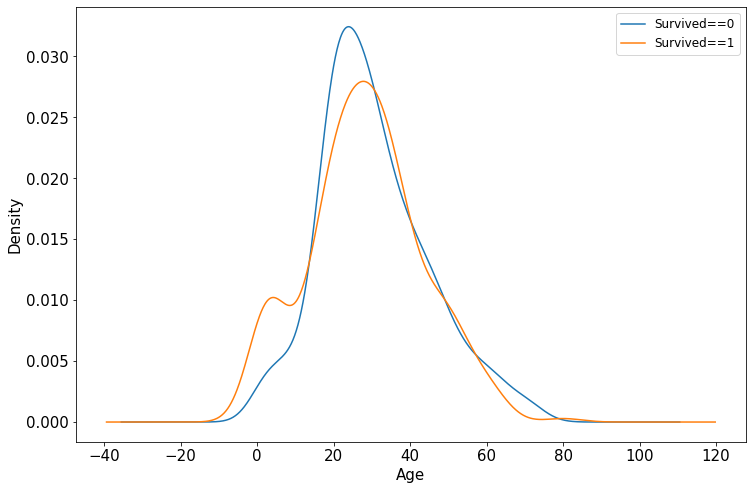

In [6]:
# 年龄和存活相关性
ax = dftrain_raw.query('Survived == 0')['Age'].plot(kind = 'density', figsize = (12,8),fontsize=15)
# 筛选出存活为0的数据与年龄做密度估计图
dftrain_raw.query('Survived == 1')['Age'].plot(kind = 'density', figsize = (12,8),fontsize=15)
# 筛选出存活为1的数据与年龄做密度估计图
ax.legend(['Survived==0','Survived==1'],fontsize = 12)
# 设置示例
ax.set_ylabel('Density',fontsize = 15)
ax.set_xlabel('Age',fontsize = 15)
plt.show()

In [7]:
def preprocessing(dfdata):
    '''
    数据预处理函数

    '''

    dfresult = pd.DataFrame()  # 建立一个空白的数据结构

    #Pclass
    dfPclass = pd.get_dummies(dfdata['Pclass'])
    # 对pclass维度进行onehot编码
    dfPclass.columns = ['Pclass_' +str(x) for x in dfPclass.columns ]
    # 更改新增列的列名，使其更好识别
    dfresult = pd.concat([dfresult,dfPclass],axis = 1)
    # 将新生成的表合并到总表里，axis=0代表横向合并，即行数不变，列数增多

    #Sex
    dfSex = pd.get_dummies(dfdata['Sex'])
    # 对性别进行onehot编码，这里不需要重新命名列，因为已经很好识别了
    dfresult = pd.concat([dfresult,dfSex],axis = 1)
    # 合并

    #Age
    dfresult['Age'] = dfdata['Age'].fillna(0)
    # 用0填充age中的所有na值
    dfresult['Age_null'] = pd.isna(dfdata['Age']).astype('int32')
    # 并将是否缺少年龄作为一个特征

    #SibSp,Parch,Fare
    dfresult['SibSp'] = dfdata['SibSp']
    dfresult['Parch'] = dfdata['Parch']
    dfresult['Fare'] = dfdata['Fare']
    # 这三个维度是可以直接使用的

    #Carbin
    dfresult['Cabin_null'] =  pd.isna(dfdata['Cabin']).astype('int32')
    # 将cabin是否缺失作为一个特征

    #Embarked
    dfEmbarked = pd.get_dummies(dfdata['Embarked'], dummy_na=True)
    # 对Embarked进行onehot处理，并将缺失值也作为一个维度
    dfEmbarked.columns = ['Embarked_' + str(x) for x in dfEmbarked.columns]
    # 更改列名
    dfresult = pd.concat([dfresult,dfEmbarked],axis = 1)

    return(dfresult)

x_train = preprocessing(dftrain_raw).values
y_train = dftrain_raw['Survived'].values
# 对训练集数据进行预处理并分别放入对应的变量中

x_test = preprocessing(dftest_raw).values
# y_test = dftest_raw['Survived'].values
# 对测试集数据进行预处理
# 这里有一个小问题，就是从kaggle下载的测试集没有标签

print("x_train.shape =", x_train.shape )
print("x_test.shape =", x_test.shape )

print("y_train.shape =", y_train.shape )
# print("y_test.shape =", y_test.shape )

x_train.shape =(891, 15)
x_test.shape =(418, 15)
y_train.shape =(891,)


In [8]:
dl_train = DataLoader(TensorDataset(torch.tensor(x_train).float(), torch.tensor(y_train).float()), shuffle=True, batch_size=8)
# 使用Dataloader封装成数据管道，打乱顺序，批次大小为8
# 疑问：为什么要转化为float

In [9]:
# 测试数据管道可用性
for features, labels in dl_train:
    print(features, labels)
    break

tensor([[  0.0000,   1.0000,   0.0000,   0.0000,   1.0000,  19.0000,   0.0000,
           0.0000,   0.0000,  10.5000,   1.0000,   0.0000,   0.0000,   1.0000,
           0.0000],
        [  1.0000,   0.0000,   0.0000,   1.0000,   0.0000,  35.0000,   0.0000,
           1.0000,   0.0000,  52.0000,   1.0000,   0.0000,   0.0000,   1.0000,
           0.0000],
        [  0.0000,   1.0000,   0.0000,   1.0000,   0.0000,  23.0000,   0.0000,
           0.0000,   0.0000,  13.7917,   0.0000,   1.0000,   0.0000,   0.0000,
           0.0000],
        [  0.0000,   0.0000,   1.0000,   0.0000,   1.0000,   0.4200,   0.0000,
           0.0000,   1.0000,   8.5167,   1.0000,   1.0000,   0.0000,   0.0000,
           0.0000],
        [  1.0000,   0.0000,   0.0000,   1.0000,   0.0000,  23.0000,   0.0000,
           3.0000,   2.0000, 263.0000,   0.0000,   0.0000,   0.0000,   1.0000,
           0.0000],
        [  0.0000,   0.0000,   1.0000,   0.0000,   1.0000,  33.0000,   0.0000,
           0.0000,   0.0000,   

二。定义模型

pytorch中主要有三种定义模型的方式：

nn.Sequential按层顺序构建

继承nn.Module基类构建自定义模型

继承nn.Module基类构建模型并辅助应用模型容器进行封装

这里使用最简单的nn.Sequential

In [10]:
def create_net():
    net = nn.Sequential()
    net.add_module('linear1', nn.Linear(15, 20))
    net.add_module('relu1', nn.ReLU())
    net.add_module('linear2', nn.Linear(20, 15))
    net.add_module('relu2', nn.ReLU())
    net.add_module('linear3', nn.Linear(15, 1))
    net.add_module('sigmoid', nn.Sigmoid())
    return net

net = create_net()
print(net)

Sequential(
  (linear1): Linear(in_features=15, out_features=20, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=20, out_features=15, bias=True)
  (relu2): ReLU()
  (linear3): Linear(in_features=15, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [11]:
from torchkeras import summary
summary(net, input_shape=(15,))
# 使用一个更加美观的表格来显示模型结构
# 还可以顺带统计模型参数数量

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 20]             320
              ReLU-2                   [-1, 20]               0
            Linear-3                   [-1, 15]             315
              ReLU-4                   [-1, 15]               0
            Linear-5                    [-1, 1]              16
           Sigmoid-6                    [-1, 1]               0
Total params: 651
Trainable params: 651
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.000057
Forward/backward pass size (MB): 0.000549
Params size (MB): 0.002483
Estimated Total Size (MB): 0.003090
----------------------------------------------------------------


三。训练模型

有三种典型的训练循环代码风格：

脚本形式

函数形式

类形式

这里使用脚本形式

In [12]:
from sklearn.metrics import accuracy_score

loss_func = nn.BCELoss()
# 二元交叉熵损失函数，主要用于二元分类问题的损失函数
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.01)
metric_func = lambda y_pred, y_true: accuracy_score(y_true.data.numpy(), y_pred.data.numpy()>0.5)
metric_name = 'accuracy'

In [13]:
epochs = 10
log_step_freq = 30

dfhistory = pd.DataFrame(columns = ["epoch","loss",metric_name,"val_loss","val_"+metric_name]) 
print('start training...')
printbar()

for epoch in range(1, epochs + 1):
    net.train()
    loss_sum = 0.0
    metric_sum = 0.0
    step = 1

    for step, (features, labels) in enumerate(dl_train, 1):

        optimizer.zero_grad()

        predictions = net(features)
        loss = loss_func(predictions, labels)
        metric = metric_func(predictions, labels)

        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        metric_sum += metric.item()
        if step % log_step_freq == 0:
            print(('[step = %d] loss: %.3f, ' + metric_name + ': %.3f') % (step, loss_sum / step, metric_sum / step))
        
    # net.eval()
    # val_loss_sum = 0.0
    # val_metric_sum = 0.0
    # val_step = 1

    # for val_step, (features, labels) in enumerate(dl_valid, 1):
    #     predictions = netdictions = net(features)
    #     val_loss = loss_func(predictions, labels)
    #     val_metric = metric_func(predictions, labels)

    #     val_loss_sum += val_loss.item()
    #     val_metric_sum += val_metric.item()
    
    # info = (epoch, loss_sum/step, metric_sum/step, val_loss_sum/val_step, val_metric_sum/val_step)
    # dfhistory.loc[epoch-1] = info
    info = (epoch, loss_sum/step, metric_sum/step)
    # dfhistory.loc[epoch-1] = info

    # 打印epoch级别日志
    # print(("\nEPOCH = %d, loss = %.3f,"+ metric_name + "  = %.3f, val_loss = %.3f, "+"val_"+ metric_name+" = %.3f") %info)
    print(("\nEPOCH = %d, loss = %.3f,"+ metric_name + "  = %.3f") %info)
    printbar()    

print('Finished Training...')

start training...

================================================================2020-07-16 10:12:16
[step = 30] loss: 0.692, accuracy: 0.600
[step = 60] loss: 0.659, accuracy: 0.633
[step = 90] loss: 0.625, accuracy: 0.661

EPOCH = 1, loss = 0.607,accuracy  = 0.683

================================================================2020-07-16 10:12:17
[step = 30] loss: 0.587, accuracy: 0.725
[step = 60] loss: 0.578, accuracy: 0.723
[step = 90] loss: 0.552, accuracy: 0.743

EPOCH = 2, loss = 0.539,accuracy  = 0.746

================================================================2020-07-16 10:12:18
[step = 30] loss: 0.582, accuracy: 0.733
[step = 60] loss: 0.532, accuracy: 0.754
[step = 90] loss: 0.519, accuracy: 0.761

EPOCH = 3, loss = 0.511,accuracy  = 0.762

================================================================2020-07-16 10:12:18
[step = 30] loss: 0.494, accuracy: 0.779
[step = 60] loss: 0.501, accuracy: 0.781
[step = 90] loss: 0.507, accuracy: 0.771

EPOCH = 4, loss = 0.